In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from random import randint
import glob

In [149]:
def get_image_names(base_name):
    score_file_name = f'../data/{base_name}.png'
    mask_file_name = f'../data/{base_name}_mask.png'
    return score_file_name, mask_file_name

def get_images(base_name):
    score_file_name, mask_file_name = get_image_names(base_name)
    mask_image = Image.open(mask_file_name).convert('L')
    mask_image = Image.eval(mask_image, lambda x: x*10) # saturate the mask
    score_image = Image.open(score_file_name)
    background = Image.new('RGBA', score_image.size, (255,255,255))
    score_image = Image.alpha_composite(background,score_image)
    score_image = score_image.convert('L')
    return score_image, mask_image

def dice_image_name(dest,prefix,count):
    return os.path.join(dest,"%s_%03d.png"%(prefix,count))

# dice up images regularly & save, but if score is completely white, then we only need to save one of those.  
# make a 2nd pass with random offsets
def dice_image_pairs(image0, image1, 
                     dest_dir, 
                     image0_prefix, image1_prefix, 
                     offset=(0,0), dice_pixels=64):
    image_count = 0
    if not os.path.isdir(dest_dir):
        print("ERROR: directory %s does not exist"%(dest_dir))
        return
    assert(image0.size == image1.size)
    saved_all_white_image = False
    all_white_images = []
    for y in range(0, image0.size[1], dice_pixels):
        for x in range(0, image0.size[0], dice_pixels):
            xx = x + offset[0]
            yy = y + offset[1]
            xx1 = xx + dice_pixels
            yy1 = yy + dice_pixels
            crop0 = image0.crop((xx,yy,xx1,yy1))
            is_all_white_image = crop0.getextrema() == (255,255)
            if ((not is_all_white_image) or
                (is_all_white_image and (not saved_all_white_image))):
                crop1 = image1.crop((xx,yy,xx1,yy1))
                #print("dump",xx,yy,is_all_white_image,saved_all_white_image)
                crop0.save(dice_image_name(dest_dir, image0_prefix, image_count))
                crop1.save(dice_image_name(dest_dir, image1_prefix, image_count))
                if is_all_white_image:
                    all_white_images = [dice_image_name(dest_dir, image0_prefix, image_count), 
                                        dice_image_name(dest_dir, image1_prefix, image_count)]
                    saved_all_white_image = True
                image_count += 1
    #print(f"diced 2x{image_count} images.")
    return all_white_images

In [167]:
# create a new set of images
!rm data/train/*png data/test/*png data/valid/*png
all_white_pairs = []
for base_name in ['chromatic', 'chromatic_piano', 'gen_one', 'gen_two', 'twinkle']:
    score_image, mask_image = get_images(base_name)
    for i in range(5):
        if i == 0:
            offset = (0,0)
        else:
            offset = (randint(-10,10), randint(-10,10))
        all_white_pairs += dice_image_pairs(score_image,mask_image, 
                                            "data/train",
                                            "diced_score_"+base_name+str(i),
                                            "diced_mask_"+base_name+str(i),
                                            offset)
# okay, there are enough of these, that I'm not worrying about train/test/valid set
len(all_white_pairs)

50

In [169]:
all_files  = glob.glob('data/train/diced_*.png')
num_images = len(all_files)
num_valid  = int(0.2*num_images)
num_test   = int(0.2*num_images)
num_train  = num_images-num_valid-num_test
print("total=%d train=%d valid=%d test=%d"%(num_images,num_train,num_valid,num_test))
# shuffle the files & then put them into new spots on the tree
# BUT, make sure to move mask & score files 
mask_files  = glob.glob('data/train/diced_mask_*.png')
mask_files  = np.random.permutation(mask_files)
for i in range(num_valid//2): 
    old_file = mask_files[i]
    new_file = old_file.replace("train","valid")
    os.rename(old_file, new_file)
    old_file = mask_files[i].replace("mask_","score_")
    new_file = old_file.replace("train","valid")
    os.rename(old_file, new_file)
for i in range(num_valid//2,num_valid//2+num_test//2): 
    old_file = mask_files[i]
    new_file = old_file.replace("train","test")
    os.rename(old_file, new_file)
    old_file = mask_files[i].replace("mask_","score_")
    new_file = old_file.replace("train","test")
    os.rename(old_file, new_file)


total=5844 train=3508 valid=1168 test=1168


In [170]:
!ls data/train/ | wc -l
!ls data/valid/ | wc -l
!ls data/test/  | wc -l

3508
1168
1168


More random code below...

In [174]:
!ls data/train/diced_*_chromatic2_02*.png

data/train/diced_mask_chromatic2_020.png
data/train/diced_mask_chromatic2_021.png
data/train/diced_mask_chromatic2_023.png
data/train/diced_mask_chromatic2_024.png
data/train/diced_mask_chromatic2_025.png
data/train/diced_score_chromatic2_020.png
data/train/diced_score_chromatic2_021.png
data/train/diced_score_chromatic2_023.png
data/train/diced_score_chromatic2_024.png
data/train/diced_score_chromatic2_025.png


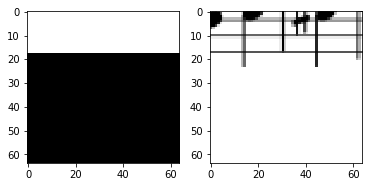

In [176]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(Image.open('data/train/diced_mask_chromatic2_020.png'),cmap='gray')
axs[1].imshow(Image.open('data/train/diced_score_chromatic2_020.png'),cmap='gray')